In [1]:
# Import DAS-N2N model class (torch version)
from dasn2n import DASN2N

# Import packages for reading, holding and plotting data
import numpy as np
import matplotlib.pyplot as plt
import obspy.core as oc

# 1. Running DAS-N2N model

## 1.1 Antarctica data from paper

In [2]:
# Load DAS-N2N model and load pre-trained weights from paper
model = DASN2N()
model.load_weights() # Loads default weights if no path given
model.half() # Uncomment if device supports accelerated half precision
model = model.to('mps') # Uncomment and use 'cuda' or 'mps' (Mac Mx chips) if GPU available

In [3]:
# Read example data from GitHub (stored as mseed for convenience):
das_data_mseed = oc.read("../data/BPT1_UTC_20200117_013019.232.mseed") # Read with obspy

# Create 2D numpy array with DAS data
das_data_numpy = np.zeros((len(das_data_mseed[0].data), len(das_data_mseed))) # (Time samples, DAS channels)
n = 0
for das_channel in das_data_mseed:
    das_data_numpy[:,n] = das_channel.data
    n += 1

In [4]:
das_data_numpy.shape # 2048 time samples, 986 channels

(2048, 986)

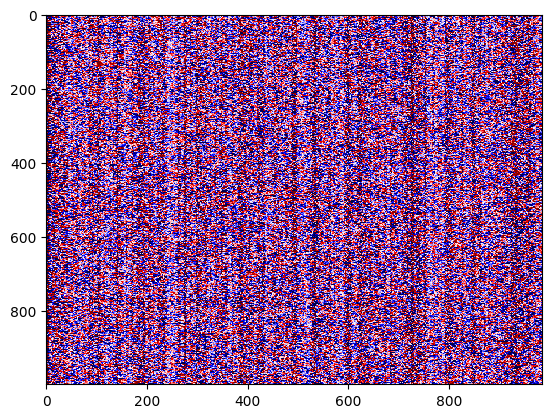

In [5]:
# Plot raw data (just first 1 sec, as per paper)
# NB It's important to use interpolation='none' to show true noise levels
plt.imshow(das_data_numpy[:1000,:], interpolation='none', cmap="seismic", vmin=-50, vmax=50, aspect="auto")
plt.show()

In [6]:
# Denoise, as per paper:
denoised_das_data = model.denoise_numpy(das_data_numpy)

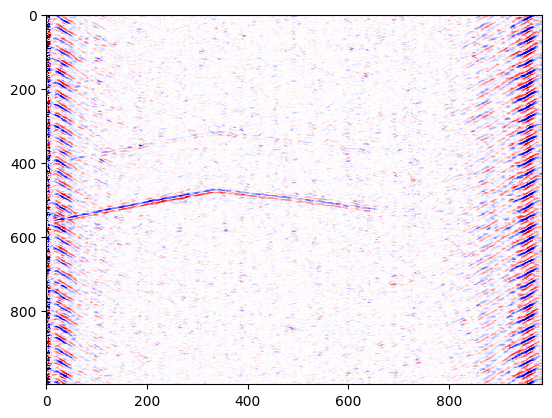

In [7]:
# Plot denoised data (just first 1 sec, as per paper)
plt.imshow(denoised_das_data[:1000,:], interpolation="none", cmap="seismic", vmin=-50, vmax=50, aspect="auto")
plt.show()

## 1.2 Utah FORGE data (not in paper)

In [8]:
# FORGE data

# Forge functions / data characteristics (https://github.com/DAS-RCN/IntroToDASData/blob/master/Forge.ipynb)

#parameters
gaugelength     = 10.0
dx_in_m         = 1.02
das_units       = 'n$\epsilon$/s'
geophone_units  = 'm/s^2'
geophone_fac    = 2.333e-7
fo_start_ch     = 197
x_zero_offset = fo_start_ch

# Functions to read DAS segy files and return as obspy streams

def populate_das_segy_trace_headers(Stream, dx_in_m=dx_in_m, network='FORGE', fo_start_ch=fo_start_ch, units=das_units):
    import pandas as pd
    for Trace in Stream:
        df = pd.DataFrame(dict(Trace.stats.segy.trace_header),index=[0]).transpose()[0]
        Trace.stats.network = network
        Trace.stats.station = '%05d' % (df.trace_sequence_number_within_line-1)
        Trace.stats.location = '0'
        Trace.stats.distance = (df.trace_sequence_number_within_line-1-fo_start_ch)  * dx_in_m
        Trace.stats.channel = 'Z'
        if units!='None':
            Trace.stats.units = units
    return Stream

def read_das_segy_files(filelist,dx_in_m=dx_in_m,fo_start_ch=fo_start_ch,units=das_units):
    import obspy.io.segy.core
    stream = obspy.Stream()
    for f in filelist:
        print('Reading '+f)
        d = obspy.io.segy.core._read_segy(f,format='segy',unpack_trace_headers=True)
        stream += populate_das_segy_trace_headers(d,dx_in_m=dx_in_m,fo_start_ch=fo_start_ch,units=das_units)
    return stream

In [9]:
# Download and read in segy file for event at 2019-04-27 17:30:31

import urllib.request
urllib.request.urlretrieve("https://pando-rgw01.chpc.utah.edu/silixa_das_apr_27_2019/FORGE_78-32_iDASv3-P11_UTC190427173023.sgy", "../data/FORGE_78-32_iDASv3-P11_UTC190427173023.sgy")

das_data_stream = read_das_segy_files(['../data/FORGE_78-32_iDASv3-P11_UTC190427173023.sgy'],
                                      dx_in_m = dx_in_m,
                                      fo_start_ch = fo_start_ch,
                                      units = das_units
                                     )

Reading ../data/FORGE_78-32_iDASv3-P11_UTC190427173023.sgy


In [10]:
# Convert obspy stream to numpy array for model processing:
das_data_numpy = np.zeros((das_data_stream[0].stats.npts, len(das_data_stream)))
for tr_no in range(len(das_data_stream)):
    das_data_numpy[:,tr_no] = das_data_stream[tr_no].data

sampling_freq = int(das_data_stream[0].stats.sampling_rate) # Get sampling frequency

In [11]:
# Denoise using default normalisation steps (remove overall file mean and std)
denoised_das_data = model.denoise_numpy(das_data_numpy)

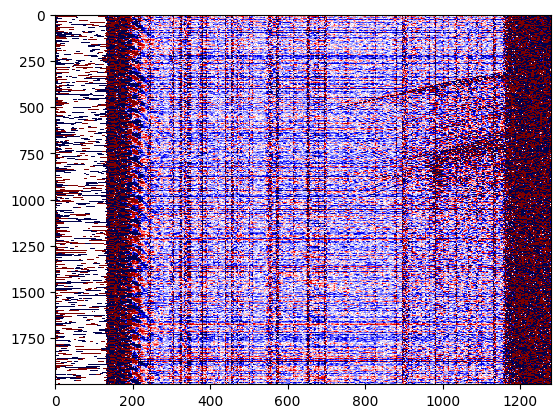

In [12]:
# Plot raw data (just 1 sec around known event)
plt.imshow(das_data_numpy[15500:17500,:], interpolation="none", cmap="seismic", vmin=-50, vmax=50, aspect="auto")
plt.show()

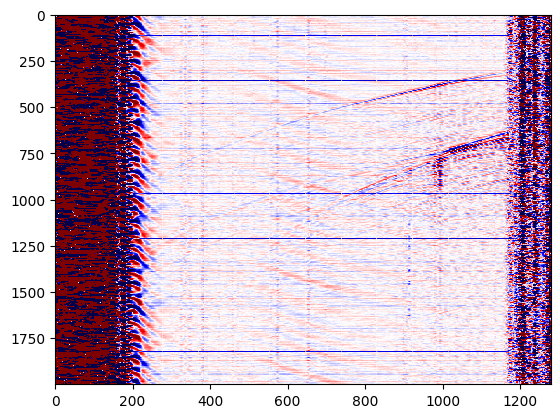

In [13]:
# Plot denoised data (just 1 sec around known event)
plt.imshow(denoised_das_data[15500:17500,:], interpolation="none", cmap="seismic", vmin=-50, vmax=50, aspect="auto")
plt.show()

In [14]:
# The denoised data has artefacts when model run with default normalisation settings
# Now recommended to use channel-wise normalisation (e.g., mean and std of each DAS channel)

denoised_das_data = model.denoise_numpy(das_data_numpy, remove_mean_axis=0, std_norm_axis=0)

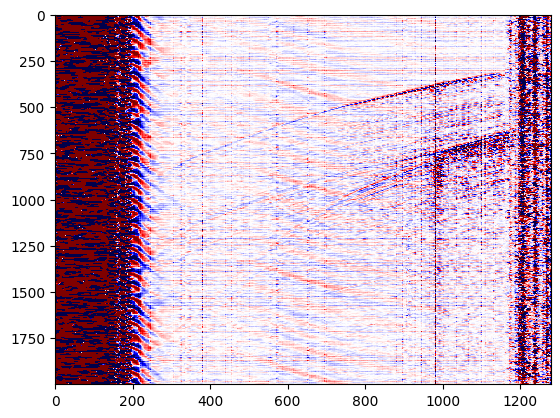

In [15]:
# Plot denoised data (just 1 sec around known event)
plt.imshow(denoised_das_data[15500:17500,:], interpolation="none", cmap="seismic", vmin=-50, vmax=50, aspect="auto")
plt.show()

In [16]:
# Data still contaminated by horizontal lines (common mode noise). 

# Do simple correction to raw data and reprocess with DASN2N.
das_data_numpy = das_data_numpy - np.mean(das_data_numpy[:,400:1100], axis=1, keepdims=True) # Remove mean at each time point from 'good' part of cable

# Re-run DASN2N
denoised_das_data = model.denoise_numpy(das_data_numpy, remove_mean_axis=0, std_norm_axis=0)

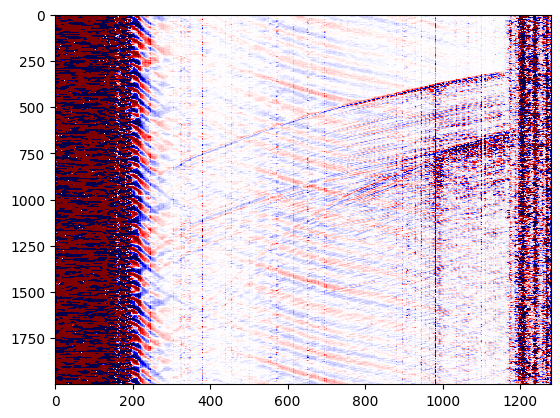

In [17]:
# Plot denoised data (just 1 sec around known event)
plt.imshow(denoised_das_data[15500:17500,:], interpolation="none", cmap="seismic", vmin=-50, vmax=50, aspect="auto")
plt.show()